In [2]:
import tensorflow as tf
from __future__ import print_function
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.preprocessing import image
from os import listdir
from os.path import isfile, join
import re
import matplotlib.image as mpimg

In [3]:
# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows = 224
img_cols = 224 

vgg16 = tf.keras.applications.vgg16.VGG16(weights = 'imagenet', include_top = False,  input_shape = (img_rows, img_cols, 3))

for layer in vgg16.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

58900480/58889256 [==============================] - 1s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [4]:
train_data_dir = 'Flower17/dataset/train'
validation_data_dir = 'Flower17/dataset/validation'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')
 
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
 
train_batchsize = 64
val_batchsize = 64
 
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols),
                                                    batch_size=train_batchsize, class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols),
                                                              batch_size=val_batchsize, class_mode='categorical', shuffle=False)

Found 1190 images belonging to 17 classes.
Found 170 images belonging to 17 classes.


In [5]:
def addTopModel(bottom_model, num_classes, D=256):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = tf.keras.layers.Flatten(name = "flatten")(top_model)
    top_model = tf.keras.layers.Dense(D, activation = "relu")(top_model)
    top_model = tf.keras.layers.Dropout(0.3)(top_model)
    top_model = tf.keras.layers.Dense(num_classes, activation = "softmax")(top_model)
    return top_model

In [6]:
num_classes = 17

FC_Head = addTopModel(vgg16, num_classes)

model = tf.keras.models.Model(inputs=vgg16.input, outputs=FC_Head)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("Flower17/testing_model/flowers_vgg_rmsprop2.h5", monitor="val_loss", mode="min", save_best_only = True,
                             verbose=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [checkpoint, reduce_lr]

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

nb_train_samples = 1190
nb_validation_samples = 170
epochs = 25
batch_size = 64

In [13]:
history = model.fit(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs, 
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

Epoch 1/25
18/18 [==============================] - 47s 1s/step - loss: 2.3368 - accuracy: 0.3366 - val_loss: 1.2386 - val_accuracy: 0.5859

Epoch 00001: val_loss improved from inf to 1.23860, saving model to Flower17/testing_model/flowers_vgg_rmsprop2.h5
Epoch 2/25
18/18 [==============================] - 22s 1s/step - loss: 1.7378 - accuracy: 0.4609 - val_loss: 0.8948 - val_accuracy: 0.7891

Epoch 00002: val_loss improved from 1.23860 to 0.89484, saving model to Flower17/testing_model/flowers_vgg_rmsprop2.h5
Epoch 3/25
18/18 [==============================] - 22s 1s/step - loss: 1.3478 - accuracy: 0.5737 - val_loss: 1.1166 - val_accuracy: 0.7031

Epoch 00003: val_loss did not improve from 0.89484
Epoch 4/25
18/18 [==============================] - 22s 1s/step - loss: 1.3763 - accuracy: 0.5728 - val_loss: 0.7695 - val_accuracy: 0.8047

Epoch 00004: val_loss improved from 0.89484 to 0.76945, saving model to Flower17/testing_model/flowers_vgg_rmsprop2.h5
Epoch 5/25
18/18 [==============

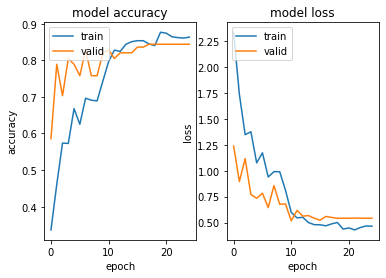

In [17]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'],loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.show()

In [18]:
trainedModel = tf.keras.models.load_model("Flower17/testing_model/flowers_vgg_rmsprop2.h5")

In [19]:
class_labels = validation_generator.class_indices
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

{0: 'bluebell', 1: 'buttercup', 2: 'colts_foot', 3: 'cowslip', 4: 'crocus', 5: 'daffodil', 6: 'daisy', 7: 'dandelion', 8: 'fritillary', 9: 'iris', 10: 'lily_valley', 11: 'pansy', 12: 'snowdrop', 13: 'sunflower', 14: 'tigerlily', 15: 'tulip', 16: 'windflower'}


In [20]:
# checking model on validation data
def getRandomImage(path, img_width, img_height):
  """function loads a random images from a random folder in our validation path """
  folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
  random_directory = np.random.randint(0,len(folders))
  path_class = folders[random_directory]
  file_path = path + path_class
  file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
  random_file_index = np.random.randint(0,len(file_names))
  image_name = file_names[random_file_index]
  final_path = file_path + "/" + image_name
  return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

In [21]:
# dimensions of our images
img_width, img_height = 224, 224

In [22]:
files = []
predictions = []
true_labels = []

In [23]:
# predicting images
for i in range(0, 5):
  path = 'Flower17/dataset/validation/' 
  img, final_path, true_label = getRandomImage(path, img_width, img_height)
  files.append(final_path)
  true_labels.append(true_label)
  x = image.img_to_array(img)
  x = x * 1./255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = np.argmax(trainedModel.predict(images, batch_size = 10))
  predictions.append(classes)


( 1 )


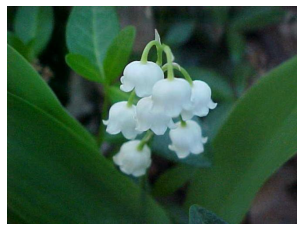

Predicted:  lily_valley
True:  lily_valley

( 2 )


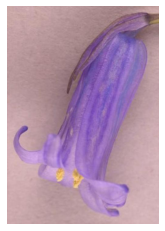

Predicted:  bluebell
True:  bluebell

( 3 )


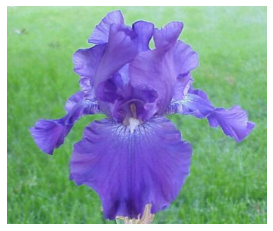

Predicted:  iris
True:  iris

( 4 )


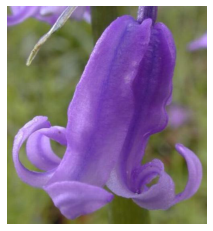

Predicted:  fritillary
True:  bluebell

( 5 )


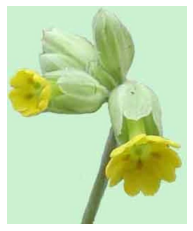

Predicted:  lily_valley
True:  cowslip


In [24]:
for i in range(0, len(files)):
  img=mpimg.imread((files[i]))
  print("\n(",i+1,")")
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  print("Predicted: ",class_labels[predictions[i]])
  print("True: ",true_labels[i])